### Shuwen Zhou Econ570 Assignment 2

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import graphviz as gr

Choose the first 3 settings

### Q1 Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates

+ simulate a DGP

In [2]:
np.random.seed(22)
n = 1000
T = np.random.binomial(1, 0.5, n)
X = np.random.normal(100,9,n)
Y = np.random.normal(5 + 6*T + 9*X, 5).astype(int)
data1 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data1.to_csv("data1.csv", index=False)

+ Illustrate DGP with a DAG

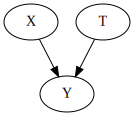

In [3]:
g = gr.Digraph()
g.edge("X", "Y")
g.edge("T", "Y")
g

+ Monte Carlo experiment

+ + case a : You do not control for any covariates

In [4]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(100,9,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(5 + 6*T + 9*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [5]:
# N=100
mcSim_100 = MC_Simulator_a(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,6.006948,6.087772
RMSE,80.186604,81.021124
treatment effect,6.006948,6.087772


+ + case b : You control for all the covariates that affect the outcome

In [27]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(100,9,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(5 + 6*T + 9*X, 5).astype(int)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [28]:
# N=100
mcSim_100 = MC_Simulator_b(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,6.094949,5.974429
RMSE,4.921386,5.000205
treatment effect,6.012293,6.007792


+ example of real-life situation that might be consistent with the DGP

Y : A person's annual income <br>
X : Years of working experiences <br>
T : Gender, whether this person is a man or woman

### Q2 Simulate a DGP with a confounder (common cause)

+ simulate a DGP

In [60]:
np.random.seed(22)
n = 1000
# generate covariate
X = np.random.normal(2,10,n)
# generate treatment
T = np.random.binomial(1, 1/(1+X**2), n)
# generate outcome
Y = np.random.normal(3 + 3*T + 3*X, 5).astype(int)
data2 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data2.to_csv("data2.csv", index=False)

+ Illustrate DGP with a DAG

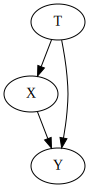

In [7]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("X", "Y")
g

+ Monte Carlo experiment

+ + case a : You fail to control for the confounder 

In [8]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(2,10,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(3 + 3*T + 3*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [9]:
# N=100
mcSim_100 = MC_Simulator_a(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,-3.491873,-3.43418
RMSE,29.745106,29.94651
treatment effect,-3.491873,-3.43418


+ + case b : You do control for the confounder

In [66]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(2,10,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(3 + 3*T + 3*X, 5).astype(int)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [67]:
# N=100
mcSim_100 = MC_Simulator_b(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,-3.452625,-3.439264
RMSE,4.875420,4.952268
treatment effect,2.748778,2.721793


+ example of real-life situation that might be consistent with the DGP

T : Whether the temperture is hot or not.<br>
Y : Number of sunburns.<br>
X : Rate of ice cream consumption.

### Q3 Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

+ simulate a DGP

In [68]:
np.random.seed(22)
n = 1000
# generate treatment
T = np.random.binomial(1, 0.5, n)
# generate outcome
Y = np.random.normal(7 + 9*T, 5).astype(int)
# generate covariate
X = np.random.normal(66+np.mean(T)*np.mean(Y),15,n)

data3 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data3.to_csv("data3.csv", index=False)

+ Illustrate DGP with a DAG

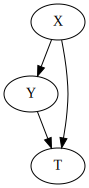

In [6]:
g = gr.Digraph()
g.edge("X", "Y")
g.edge("X", "T")
g.edge("Y", "T")
g

+ Monte Carlo experiment

+ + case a : You control for the variable in between the path from cause to effect

In [70]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(7 + 9*T, 5).astype(int)
        X = np.random.normal(66+np.mean(T)*np.mean(Y),15,n)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [71]:
# N=100
mcSim_100 = MC_Simulator_a(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,8.930458,8.922938
RMSE,4.845301,4.927454
treatment effect,8.930900,8.922682


+ + case b : You do not control for the variable in between the path from cause to effect

In [72]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(7 + 9*T, 5).astype(int)
        X = np.random.normal(66+np.mean(T)*np.mean(Y),15,n)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [73]:
# N=100
mcSim_100 = MC_Simulator_b(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,8.930014,8.926696
RMSE,4.875160,4.929840
treatment effect,8.930014,8.926696


+ example of real-life situation that might be consistent with the DGP

T : Need hospitalization or not.<br>
Y : Respiratory disease.<br>
X : Locomotor disease.